## U-Net with padding, with colorjitter
UN_1000_50e --> UN_10000_20e_aug<br>
Continue train UN_1000_50e.pth on 10000 train images for 20 epochs.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from PIL import Image
from torch.utils import data
import time
import os
import copy
import json
import random

# plt.ion()   # interactive mode

In [3]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
def Train_transform(image,mask,flip=True):
    image = tf.resize(image, (224,224))
    mask = tf.resize(mask, (224,224)) 
    
    if flip==True:
        if random.random() > 0.5:
            image = tf.hflip(image)
            mask = tf.hflip(mask)
        if random.random() > 0.5:
            image = tf.vflip(image)
            mask = tf.vflip(mask)
        image = tf.adjust_contrast(image,random.uniform(0.5,2))
        image = tf.adjust_hue(image,random.uniform(-0.5,0.5))
        image = tf.adjust_brightness(image,random.uniform(0.5,2))
    
    image = tf.to_tensor(image)
    mask = tf.to_tensor(mask)
    image = tf.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return image, mask

def Other_transform(image,mask):
    return Train_transform(image,mask,False)

data_transform = {'train': Train_transform, 'eval': Other_transform, 'test': Other_transform}

In [5]:
class LIPDataset(data.Dataset):
    
    def __init__(self, root=None, img_path=None, mask_path=None, num_images=300, transform=None):   
        
        self.root = root
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform
        
        self.table=[1]*256
        self.table[0]=0
        
        self.images = []
        self.masks = []
        c = 0
        for img in list(sorted(os.listdir(os.path.join(root,img_path)))):
            if c == num_images:
                break
            c+=1
            p = os.path.join(os.path.join(root,img_path),img)
            if self.is_valid_image(p):
                self.images.append(p)
            else:
                print('img failed to be opened:')
                print(p)
        c = 0
        for mask in list(sorted(os.listdir(os.path.join(root,mask_path)))):
            if c == num_images:
                break
            c+=1
            p = os.path.join(os.path.join(root,mask_path),mask)
            if self.is_valid_image(p):
                self.masks.append(p)
            else:
                print('mask failed to be opened:')
                print(p)
        
    def is_valid_image(self, path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid
        
    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        mask = mask.point(self.table,'1')
        if self.transform:
            image, mask = self.transform(image,mask)
        return image, mask
   
    def __len__(self):
        return len(self.images)

In [6]:
def load_data(TRAIN_BS, num_train, num_eval):
    data_dir = {'root': '/kaggle/input/singleperson', 
                'train': ('TrainVal_images/TrainVal_images/train_images','TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/train_segmentations',num_train),
                'eval': ('TrainVal_images/TrainVal_images/val_images','TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations',num_eval),
#                 'test': ('Testing_images/Testing_images/testing_images', )
               }
    since = time.time()
    datasets = {x: LIPDataset(data_dir['root'], data_dir[x][0], data_dir[x][1], data_dir[x][2], data_transform[x]) for x in ['train', 'eval']}
    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'eval']}
    print(dataset_sizes)
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['eval']}
    dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'], batch_size=TRAIN_BS, shuffle=True, num_workers=4)
    time_elapsed = time.time() - since
    print('Data loading complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    return datasets, dataloaders, dataset_sizes, device

In [7]:
def imshow(phase):
    print(phase + ' images:')
    imgs, masks = next(iter(dataloaders[phase]))
    im = torchvision.utils.make_grid(imgs)
    im = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = std * im + mean
    im = np.clip(im, 0, 1)
    plt.imshow(im);
    plt.pause(0.001)
    ma = torchvision.utils.make_grid(masks)
    ma = ma.numpy().transpose((1, 2, 0))
    ma = np.clip(ma, 0, 1)
    plt.imshow(ma);
    plt.pause(0.001)

In [8]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.up(x)
        return x

    
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=3,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,1,kernel_size=1,stride=1,padding=0)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_() 
    
    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return torch.sigmoid(d1)

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, sch=False):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    o = outputs.cuda().data.cpu().numpy()
                    preds = torch.tensor((o>0.5).astype(np.float32)).to(device)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        if sch:
                            scheduler.step(epoch + step / iters)
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase] / outputs.size(-1)**2
            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    return model, statistics, lrs

In [10]:
def visualize_accuracy(num_epochs, statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.savefig(fig_name)

In [11]:
def get_fixed_imgs():
    phases = ['train','eval']
    subsets = {x: torch.utils.data.Subset(datasets[x], np.arange(8)) for x in phases}
    new_loader= {x: torch.utils.data.DataLoader(subsets[x], batch_size=8, shuffle=False) for x in phases}
    dic = {x:{} for x in phases} # 'images','masks','outputs','preds'
    for phase in phases:
        inputs, labels = next(iter(new_loader[phase]))
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        o = outputs.cuda().data.cpu().numpy()
        preds = torch.tensor((o>0.5).astype(np.float32)).to(device)
        dic[phase]['images'] = inputs
        dic[phase]['masks'] = labels
        dic[phase]['outputs'] = outputs
        dic[phase]['preds'] = preds
    return dic

In [12]:
def visualize_performance(dic):
    fig = plt.figure()
    for keys,values in dic.items():
        print('Several images in ' + keys + ':')
        for k,v in values.items():
#             fig = plt.figure()
            im = torchvision.utils.make_grid(v[:8,:,:,:], nrow=4)
            im = im.cuda().data.cpu().numpy().transpose((1, 2, 0))
            if k == 'images':
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                im = std * im + mean
            im = np.clip(im, 0, 1)
            plt.imshow(im);
            plt.title(k)
            plt.pause(0.001)
    fig.show()

{'train': 10000, 'eval': 1000}
Data loading complete in 0m 37s
cuda:0
train images:


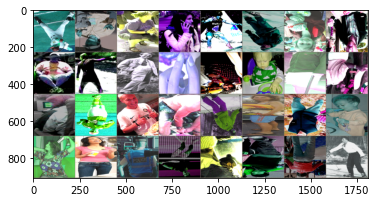

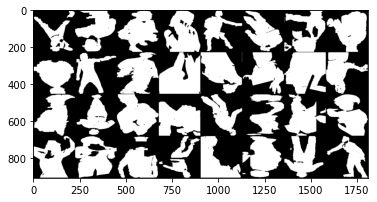

Epoch 0/19
----------
train Loss: 0.1731 Acc: 0.7450
eval Loss: 0.1299 Acc: 0.8184

Epoch 1/19
----------
train Loss: 0.1567 Acc: 0.7716
eval Loss: 0.1202 Acc: 0.8303

Epoch 2/19
----------
train Loss: 0.1494 Acc: 0.7830
eval Loss: 0.1168 Acc: 0.8369

Epoch 3/19
----------
train Loss: 0.1451 Acc: 0.7902
eval Loss: 0.1141 Acc: 0.8411

Epoch 4/19
----------
train Loss: 0.1422 Acc: 0.7946
eval Loss: 0.1169 Acc: 0.8348

Epoch 5/19
----------
train Loss: 0.1389 Acc: 0.7995
eval Loss: 0.1080 Acc: 0.8501

Epoch 6/19
----------
train Loss: 0.1361 Acc: 0.8049
eval Loss: 0.1059 Acc: 0.8518

Epoch 7/19
----------
train Loss: 0.1339 Acc: 0.8084
eval Loss: 0.1071 Acc: 0.8492

Epoch 8/19
----------
train Loss: 0.1312 Acc: 0.8126
eval Loss: 0.1034 Acc: 0.8562

Epoch 9/19
----------
train Loss: 0.1294 Acc: 0.8151
eval Loss: 0.1035 Acc: 0.8550

Epoch 10/19
----------
train Loss: 0.1270 Acc: 0.8192
eval Loss: 0.1027 Acc: 0.8558

Epoch 11/19
----------
train Loss: 0.1260 Acc: 0.8208
eval Loss: 0.1030 Acc

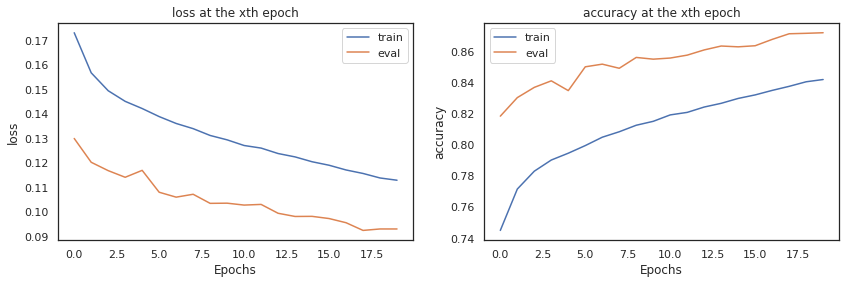

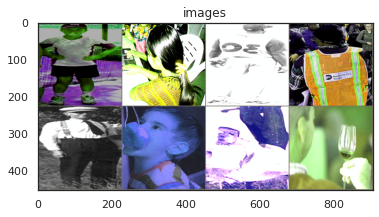

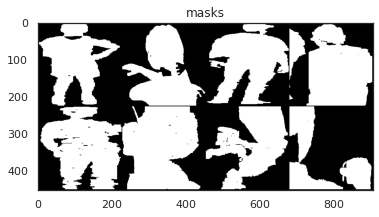

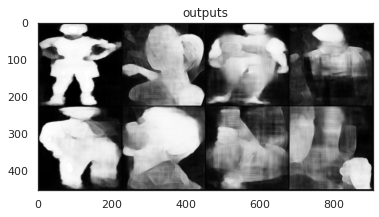

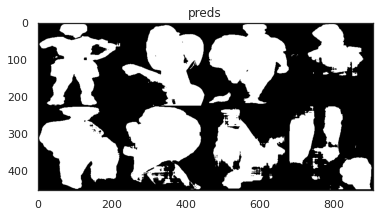

Several images in eval:


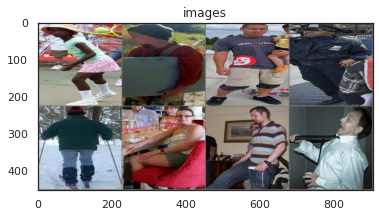

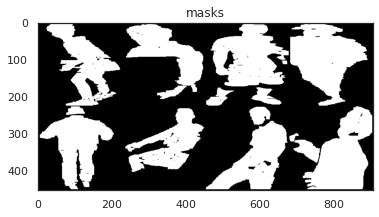

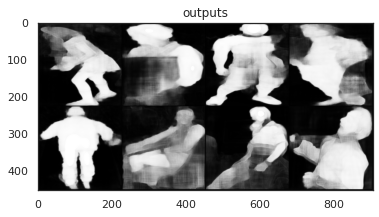

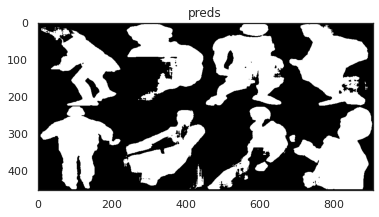

In [13]:
setup_seed(20)
datasets, dataloaders, dataset_sizes, device = load_data(32, 10000, 1000)
imshow('train')

model = UNet()
model.load_state_dict(torch.load('/kaggle/input/trainedunet/UN_1000.pth'))
model = model.to(device)
num_epochs = 20
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
cosine_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0= int(1.3*num_epochs), T_mult=1, eta_min=0, last_epoch=-1)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=2, min_lr=1e-08, eps=1e-08)
model, statistics, lrs = train_model(model, criterion, optimizer, cosine_lr_scheduler, num_epochs=num_epochs, sch=False)

name = 'UN_10000_20e_aug'

json.dump(statistics, open(name+'.json', 'w'))
visualize_accuracy(num_epochs, statistics, name+'.png')
dic = get_fixed_imgs()
visualize_performance(dic)
torch.save(model.state_dict(), '/kaggle/working/'+name+'.pth')